## Решение задачи:

Выполним установку токенизатора **Razdel**, загрузим предобученные **Embedding**.
И установим большую базу текстов на русском языке - **navec**.

In [ ]:
!pip install razdel
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec

--2025-05-05 09:27:41--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  12.4MB/s    in 5.9s    

2025-05-05 09:27:49 (8.51 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



Установим необходимые библиотеки для дальнейшей работы, а также укажем параметры для "**скользящего окна**".

In [ ]:
from sklearn.model_selection import train_test_split
from navec import Navec
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, SpatialDropout1D, BatchNormalization, Dropout, Bidirectional, LSTM, GRU
import keras
from razdel import tokenize
import glob
import random
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline


WIN_SIZE = 1000 #размер окна
WIN_STEP = 100 #шаг

Воспользуемся новым методом для нас загрузки датасета, описанным в официальной документации **Keras**. Данный метод позволяет избежать повторной загрузки, если данные были раньше скачаны. Метод возвращает путь к папке с датасетом.

In [ ]:
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

21547079/21547079 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Разархивируем датасета во временную папку *dataset:*

In [ ]:
!unzip -qo "{data_path}" -d ./dataset

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


Отберем для обучения 12 писателей:

In [ ]:
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Blok", "Pushkin", "Gogol", "Gorky", "Herzen", "Bryusov", "Nekrasov" ]

Следующий код собирает текстовые данные из файлов в структуру словаря *all_texts*, где *ключи* — это имена авторов, а *значения* — объединённые тексты всех их произведений.

In [ ]:
all_texts = {} #собираем в словарь весь датасет

for author in CLASS_LIST:
    all_texts[author] = '' #инициализируем пустой строкой новый ключ словаря
    for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): #поиск файлов по шаблону
        with open(f'{path}', 'r', errors='ignore') as f: #игнорируем ошибки (например символы из другой кодировки)
            text = f.read() #загрузка содержимого файла в строку

        all_texts[author]  += ' ' + text.replace('\n', ' ') #заменяем символ перехода на новую строку пробелом

Далее выполним подсчёт популярности слов (токенов) в текстах из словаря *all_texts* и создадим словарь наиболее частых токенов (*word_index*), который можно использовать для векторизации текста.

**Razdel** — это библиотека для токенизации русского текста (разбиения на слова и знаки препинания).

Функция `razdel_tokenize(text)` принимает текст и возвращает список токенов (отдельных слов и символов).

In [ ]:
#реализация токенизатора Razdel
def razdel_tokenize(text):
    return [token.text for token in tokenize(text)]

token_counts = defaultdict(int)
max_words = 15000 #укажем размер словаря

#подсчет частотности токенов
for text in all_texts.values():
    tokens = razdel_tokenize(text.lower())
    for token in tokens:
        token_counts[token] += 1

sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:max_words] #сортируем токены по частоте и берем top-N
word_index = {word: i+1 for i, (word, count) in enumerate(sorted_tokens)}  #+1 потому что 0 зарезервирован

Преобразуем тексты из словаря *all_texts* в числовые последовательности, используя ранее созданный словарь *word_index*. Каждое слово заменяется на соответствующий ему числовой индекс, а неизвестные слова (которых нет в *word_index*) заменяются на 0:

In [ ]:
seq_train = []
for text in all_texts.values():
    tokens = razdel_tokenize(text)
    seq = [word_index.get(token, 0) for token in tokens if word_index.get(token, 0) < max_words]
    seq_train.append(seq)

Вычисляем общее количество слов в датасете:

In [ ]:
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 7595915 слов


Далее будет представлена общая выборка по писателям, их доля в базе данных, среднее и медианное значение слов:

In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls]) / total * 100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls])) #собирает данные о длинах текстов для последующей балансировки датасета

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 2256297 слов, доля в общей базе: 29.70%
Tolstoy - 1860484 слов, доля в общей базе: 24.49%
Turgenev - 474891 слов, доля в общей базе: 6.25%
Chekhov - 376424 слов, доля в общей базе: 4.96%
Lermontov - 70916 слов, доля в общей базе: 0.93%
Blok - 117790 слов, доля в общей базе: 1.55%
Pushkin - 271928 слов, доля в общей базе: 3.58%
Gogol - 433094 слов, доля в общей базе: 5.70%
Gorky - 888669 слов, доля в общей базе: 11.70%
Herzen - 241466 слов, доля в общей базе: 3.18%
Bryusov - 531981 слов, доля в общей базе: 7.00%
Nekrasov - 71975 слов, доля в общей базе: 0.95%
Среднее значение слов:  632993.0
Медианное значение слов:  404759.0


Далее необходимо выполнить сбалансированную выборку и из оставшихся писателей отобрать 4 случайным образом:

In [ ]:
#сбалансированная выборка
median = int(np.median(mean_list))  #зафиксировали медианное значение
seq_train_balance = []
CLASS_LIST_BALANCE = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
        seq_train_balance.append(seq_train[cls][:median])
        CLASS_LIST_BALANCE.append(author)

#cлучайный выбор 4 писателей из сбалансированного списка
selected_authors = random.sample(CLASS_LIST_BALANCE, 4)
selected_seq_train_balance = [seq_train_balance[CLASS_LIST_BALANCE.index(author)] for author in selected_authors]

Далее будет представлена сбалансированная выборка по писателям, их доля в общей базе данных, среднее и медианное значение слов:

In [ ]:
total = sum(len(i) for i in selected_seq_train_balance)
print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author, seq in zip(selected_authors, selected_seq_train_balance):
    print(f'{author} - {len(seq)} слов, доля в общей базе: {len(seq)/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Gogol - 404759 слов, доля в общей базе: 27.76%
Chekhov - 376424 слов, доля в общей базе: 25.82%
Turgenev - 404759 слов, доля в общей базе: 27.76%
Pushkin - 271928 слов, доля в общей базе: 18.65%
Среднее значение слов:  364468.0
Медианное значение слов:  390591.5


Затем создадим круговую диаграмму, в которой будут представлены 4 писателей и их доля текста в общей базе данных:

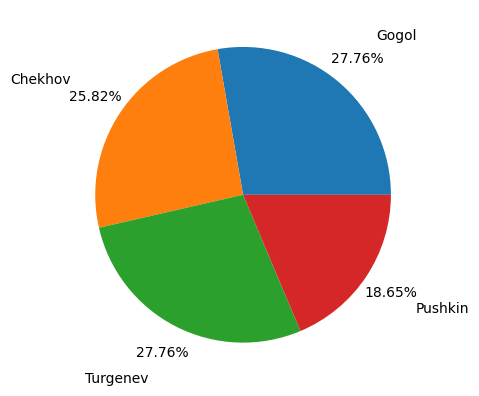

In [ ]:
#построение диаграммы
fig, ax = plt.subplots()
ax.pie([len(i) for i in selected_seq_train_balance],
       labels=selected_authors,
       pctdistance=1.2,
       labeldistance=1.4,
       autopct='%1.2f%%')
plt.show()

Далее реализуем 2 функции, а именно: **seq_split**, которая отвечает за разбиение последовательности чисел на небольшие "окна" фиксированной длины и **seq_vectorize**, которая осуществляет подготовку данных для нейросетей с разделением на обучение/валидацию/тест:

In [ ]:
def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]

def seq_vectorize(seq_list, test_split, val_split, class_list, win_size, step):
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    #обрабатываем каждую последовательность
    for class_idx, seq in enumerate(seq_list):
        #вычисляем границы разделения последовательности
        total_len = len(seq)
        val_end = int(total_len * (1 - test_split - val_split))
        test_end = int(total_len * (1 - test_split))

        #разбиваем последовательность на окна для каждой части
        train_windows = seq_split(seq[:val_end], win_size, step)
        val_windows = seq_split(seq[val_end:test_end], win_size, step)
        test_windows = seq_split(seq[test_end:], win_size, step)

        #добавляем окна в соответствующие списки
        x_train += train_windows
        x_val += val_windows
        x_test += test_windows

        #создаем one-hot метки и добавляем их в соответствующие списки
        #количество меток равно количеству окон
        y_train += [keras.utils.to_categorical(class_idx, len(class_list))] * len(train_windows)
        y_val += [keras.utils.to_categorical(class_idx, len(class_list))] * len(val_windows)
        y_test += [keras.utils.to_categorical(class_idx, len(class_list))] * len(test_windows)

    #преобразуем списки в numpy массивы и возвращаем результат
    return (np.array(x_train), np.array(y_train),
            np.array(x_val), np.array(y_val),
            np.array(x_test), np.array(y_test))

Выполним финальную подготовку данных для обучения нейросетевой модели, преобразуя тексты в числовой формат и разделяя их на обучающую, валидационную и тестовую выборки:

In [ ]:
x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(
    selected_seq_train_balance, #используем сбалансированную выборку из 4 авторов
    test_split=0.1,
    val_split=0.1,
    class_list=selected_authors, #передаём только выбранных 4 авторов
    win_size=WIN_SIZE,
    step=WIN_STEP
)

Убедимся в корректности распределения данных:

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (11626, 1000)
Форма выходных данных (меток) для обучающей выборки: (11626, 4)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1419, 1000)
Форма выходных данных (меток) для тестовой выборки: (1419, 4)


In [ ]:
print(f'Форма входных данных для валидационной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для валидационной выборки: {y_val.shape}')

Форма входных данных для валидационной выборки: (1419, 1000)
Форма выходных данных (меток) для валидационной выборки: (1419, 4)


Напишем 2 функции, а именно: **show_plot**, которая отвечает за отрисовку графиков точности и ошибки, и **show_confusion_matrix**, которая выводит матрицу ошибок и предсказанные значения:

In [ ]:
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) #на оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, class_labels):
    #матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')

    cm = np.around(cm, 3) #округление значений матрицы ошибок

    #отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  #убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45) #наклон меток горизонтальной оси
    plt.show()


    #средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

Загрузим предобученную модель, инициализируем матрицу эмбеддингов и заполним матрицы векторами слов:

`hudlit_12B_500K_300d_100q` — это **GloVe-эмбединги** обученные на 145ГБ художественной литературы. Архив с текстами взят из проекта **RUSSE** и использует оригинальную реализацию GloVe на C, обернутую в удобный Python-интерфейс.

Размер словаря `hudlit_12B_500K_300d_100q` — 500 000 записей, он покрывает 98% слов в художественных текстах. Оптимальная размерность векторов — 300. Таблица 500 000 × 300 из float-чисел занимает 578МБ, размер архива с весами `hudlit_12B_500K_300d_100q` в 12 раз меньше (48МБ). И это благодаря **квантизации**.

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
embedding_matrix = np.zeros((max_words, 300))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = navec.get(word)
        if embedding_vector is not None: #слова, которых нет в Navec (или с индексом >= max_words), получают нулевой вектор
            embedding_matrix[i] = embedding_vector

Так как мы используем предварительно сформированные векторные представления, то это накладывает ограничения на размерность входного слоя `Embedding` нашей модели (смотрим по имени файла navec_hudlit_v1_12B_500K_**300d**_100q.tar):

Слой Embedding в качестве весов использует - двумерную матрицу с вещественными числами, каждый `i`-й элемент которой — это вектор, связанный с `i`-м словом в индексе. Все довольно просто. Загрузим подготовленную матрицу в слой `Embedding` с помощью параметра `weights`.

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 300, input_length=WIN_SIZE, weights=embedding_matrix))
model.add(SpatialDropout1D(0.3))
model.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Два рекуррентных слоя GRU
model.add(GRU(32, return_sequences=True, reset_after=True))
model.add(GRU(32, reset_after=True))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Дополнительный полносвязный слой
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(len(selected_authors), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Выполним разделение данных (*train_test_split*), настроим 3 callbacks, а именно:**EarlyStopping**, **ReduceLROnPlateau** и **ModelCheckpoint**:

In [ ]:
x_train_final, x_val_final, y_train_final, y_val_final = train_test_split(
    x_train,
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=0
)

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

Выполним компиляцию модели и приступим к её обучению:

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    x_train_final, y_train_final,
    epochs=100,
    batch_size=256,
    validation_data=(x_val_final, y_val_final),
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 402ms/step - accuracy: 0.2648 - loss: 1.7739 - val_accuracy: 0.2889 - val_loss: 1.3655 - learning_rate: 0.0010
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 386ms/step - accuracy: 0.3282 - loss: 1.4880 - val_accuracy: 0.3732 - val_loss: 1.3402 - learning_rate: 0.0010
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step - accuracy: 0.4342 - loss: 1.2828 - val_accuracy: 0.4832 - val_loss: 1.1979 - learning_rate: 0.0010
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.5317 - loss: 1.1271 - val_accuracy: 0.5408 - val_loss: 1.0934 - learning_rate: 0.0010
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.6129 - loss: 0.9764 - val_accuracy: 0.5761 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 378ms/step - accuracy: 0.6742 - loss: 0.8573 - val_accuracy: 0.5701 - val_loss: 1.2119 - learning_rate: 0.0010
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 0.6670 - l

Воспользуемся функцией **show_plot**:

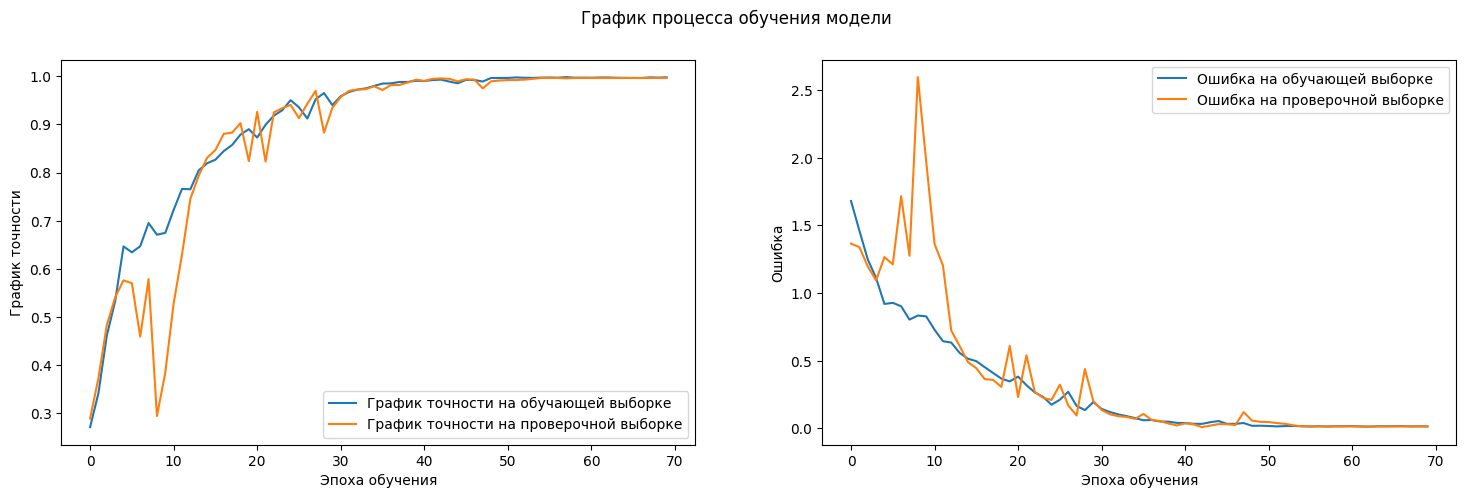

In [ ]:
show_plot(history)

Загружаем лучшую сохранённую версию, тестируем её на данных, которые модель не видела при обучении, визуализируем ошибки для анализа:

45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9082 - loss: 0.3198
Лучшая модель на валидации: точность = 94.15%
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9530 - loss: 0.1644
Лучшая модель на тестах: точность = 92.18%
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step


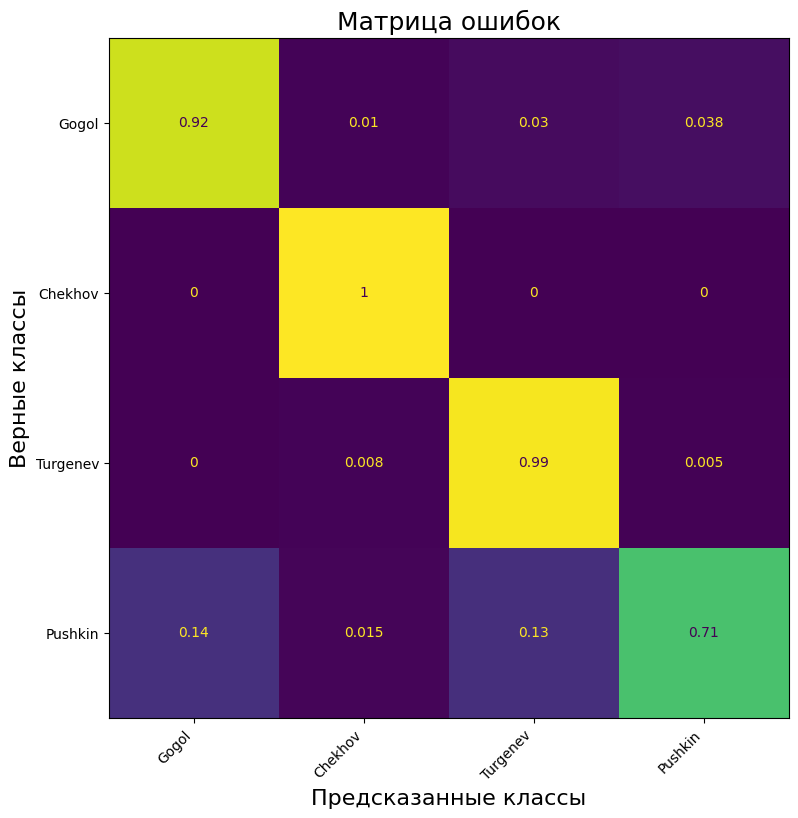


Средняя точность распознавания:  91%


In [ ]:
best_model = load_model('best_model.keras')

val_loss, val_acc = best_model.evaluate(x_val, y_val)
print(f"Лучшая модель на валидации: точность = {val_acc:.2%}")

test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Лучшая модель на тестах: точность = {test_acc:.2%}")

y_pred = best_model.predict(x_test)
show_confusion_matrix(y_test, y_pred, selected_authors)

Теперь выполним дополнительное задание, где предложим нейронке предсказать на кого из русских писателей похож наш текст:

In [ ]:
#загрузка и предварительная обработка текста из файла
with open('text.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read()

tokens = razdel_tokenize(text.lower()) #токенизация текста

seq = [word_index.get(token, 0) for token in tokens if word_index.get(token, 0) < max_words] #преобразование токенов в последовательность индексов

windows = seq_split(seq, WIN_SIZE, WIN_STEP) #разбиение последовательности на окна

x_predict = np.array(windows)

y_predict = best_model.predict(x_predict)

predicted_class_idx = np.argmax(np.mean(y_predict, axis=0))
predicted_author = selected_authors[predicted_class_idx]

print(f"Текст похож на произведение автора: {predicted_author}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Текст похож на произведение автора: Turgenev
